# Project: Facial Recognition with Emotion & Liveness
**Course:** COS30082 Applied Machine Learning

---

## 1. Introduction

This project aims to design and implement an end-to-end **face recognition attendance system**. The system is required to have three main components:

1.  **Face Verification:** To identify if a person is registered in the database.
2.  **Anti-Spoofing Module:** A liveness detection system to prevent spoofing from photos or screens.
3.  **Emotion Detection Module:** To analyze and display the user's emotional state.

This notebook focuses on the core **Face Verification** component. As required by the project specifications, we will implement and compare two distinct approaches for generating discriminative face embeddings:

* **Approach A: Supervised Learning (Classification-Based):** We will train a CNN as a multi-class classifier on known identities from the `train_data` folder. The features from the pre-softmax layer will then be extracted as the face embedding.
* **Approach B: Metric Learning (Self-Supervised):** We will train a CNN using a metric learning approach (like triplet loss). This method learns to map similar faces close together and different faces are far apart in the embedding space.

Finally, we will evaluate both models against the provided validation set (`verification_pairs_val.txt`) and compare their performance.

## 2. Approach A: Supervised Learning (Classification-Based)

This first approach treats face verification as a **classification problem**. We utilize the modern **EfficientNetV2S** architecture as our backbone. EfficientNetV2 offers faster training speeds and better parameter efficiency compared to the original EfficientNet (B0-B7) series.

**Key Implementation Details:**
* **Backbone:** EfficientNetV2S (Small), pre-trained on ImageNet.
* **Input Size:** $260 \times 260$ pixels (optimized for V2S performance vs. speed trade-off).
* **Optimization:** We utilize **Mixed Precision (Float16)** training to reduce memory usage and speed up computations on the GPU.

**Training Strategy:**
Once the model is trained to classify the 4000 identities, we discard the final classification (Softmax) layer. The output of the preceding layer (the `embedding_dense` layer) is used as the **face embedding**. We employ a two-stage training process:
1.  **Stage 1 (Warm-up):** We freeze the V2S backbone and train only the new classification head to initialize weights.
2.  **Stage 2 (Fine-Tuning):** We unfreeze the top 20% of the backbone and train with a lower learning rate to adapt the high-level features to facial recognition tasks.

In [1]:
%pip install protobuf==4.25.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 5.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.25.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 4.25.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatibl

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import os
import numpy as np
# We import the specific V2 module
from tensorflow.keras.applications import efficientnet_v2

# --- OPTIMIZATION 1: Mixed Precision ---
# Mixed precision uses 16-bit floating-point numbers for calculation (faster, less memory)
# and 32-bit for variable storage (stability).
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print(f"Policy set to: {policy.name}")

# --- Hyperparameters ---
# 260x260 is a sweet spot for EfficientNetV2S transfer learning (native is usually higher, 
# but 260 is significantly faster while retaining high accuracy).
IM_SIZE = 260         
BATCH_SIZE = 64       # Increased batch size possible due to Mixed Precision
EMBEDDING_DIM = 512   # Size of the vector representation for the face
EPOCHS_STAGE_1 = 10   # Epochs for training only the head
EPOCHS_STAGE_2 = 15   # Epochs for fine-tuning the backbone
LEARNING_RATE_STAGE_1 = 1e-3 
LEARNING_RATE_STAGE_2 = 1e-5 

# --- Paths ---
BASE_DIR = "/kaggle/input/project-dataset/11-785-fall-20-homework-2-part-2-2/classification_data"
train_dir = os.path.join(BASE_DIR, "train_data") 
val_dir = os.path.join(BASE_DIR, "val_data")     

OUTPUT_MODEL_PATH = "face_embedding_model.keras"

# --- Data Pipeline ---

def create_classification_dataset(data_dir, batch_size):
    """
    Creates a highly optimized tf.data.Dataset for image classification.
    
    Args:
        data_dir (str): Path to the directory containing class subfolders.
        batch_size (int): Number of images per batch.
        
    Returns:
        tuple: (tf.data.Dataset object, integer number of classes)
    """
    # Load image dataset from directory
    # label_mode='int' is used for SparseCategoricalCrossentropy
    dataset = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        label_mode='int', 
        batch_size=batch_size,
        image_size=(IM_SIZE, IM_SIZE),
        shuffle=True,
        validation_split=0.0, # We handle validation sets manually via directory
    )

    num_classes = len(dataset.class_names)
    print(f"Found {num_classes} classes in {data_dir}.")

    def preprocess_batch(image, label):
        """
        Applies specific preprocessing required by EfficientNetV2.
        EfficientNetV2 expects inputs in [0, 255] usually, but using the explicit
        function ensures internal logic (like rescaling) is handled correctly.
        """
        return efficientnet_v2.preprocess_input(image), label

    # Apply preprocessing and prefetching
    # AUTOTUNE allows TensorFlow to manage buffer sizes dynamically for performance
    dataset = dataset.map(preprocess_batch, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset, num_classes

# --- Model Building ---

def build_classification_model(embedding_dim, num_classes):
    """
    Constructs the architecture using EfficientNetV2S as the feature extractor.
    
    Structure: Input -> EfficientNetV2S (Frozen) -> Dense (Embedding) -> Dropout -> Dense (Logits) -> Softmax
    
    Args:
        embedding_dim (int): Dimension of the face embedding (e.g., 512).
        num_classes (int): Total number of identities to classify.
        
    Returns:
        tuple: (training_model, embedding_model, backbone_layer)
    """
    inputs = layers.Input(shape=(IM_SIZE, IM_SIZE, 3))

    # Load EfficientNetV2S pre-trained on ImageNet
    # include_top=False removes the 1000-class ImageNet classification layer
    # pooling='avg' applies GlobalAveragePooling2D immediately after the backbone
    backbone = efficientnet_v2.EfficientNetV2S(
        weights="imagenet",
        include_top=False,
        input_shape=(IM_SIZE, IM_SIZE, 3),
        pooling='avg' 
    )

    # Freeze backbone initially for Transfer Learning
    backbone.trainable = False

    # Pass inputs through backbone
    # training=False ensures BatchNormalization layers run in inference mode,
    # maintaining the statistics learned from ImageNet.
    x = backbone(inputs, training=False) 

    # Embedding Layer (This is the vector we will eventually want)
    embedding_layer = layers.Dense(embedding_dim, name='embedding_dense')(x)
    
    # Dropout for regularization to prevent overfitting
    x_head = layers.Dropout(0.3)(embedding_layer)
    
    # Classification Head
    # We separate the Dense layer and Activation for Mixed Precision stability.
    # The output of the network MUST be float32, not float16.
    outputs = layers.Dense(num_classes, name='classification_logits')(x_head)
    outputs = layers.Activation('softmax', dtype='float32', name='classification_output')(outputs)

    # Create two models: one for training, one for generating embeddings later
    training_model = Model(inputs=inputs, outputs=outputs)
    embedding_model = Model(inputs=inputs, outputs=embedding_layer)

    return training_model, embedding_model, backbone

# --- Custom Callback (Unchanged) ---
class SaveEmbeddingModelCallback(tf.keras.callbacks.Callback):
    """
    A custom callback to save ONLY the embedding part of the model (Backbone + Embedding Layer),
    discarding the huge classification head (which is useless for verification).
    """
    def __init__(self, embedding_model, filepath, monitor='val_accuracy', mode='max'):
        super().__init__()
        self.embedding_model = embedding_model
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.best = -np.inf if mode == 'max' else np.inf
        self.has_saved = False

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current = logs.get(self.monitor)
        
        # Fallback if validation metric isn't available (e.g., if val set is empty)
        if current is None: 
            current = logs.get(self.monitor.replace("val_", ""))
        if current is None: return

        # Check if result improved
        if (self.mode == 'max' and current > self.best) or (self.mode == 'min' and current < self.best):
            print(f"\nEpoch {epoch+1}: {self.monitor} improved from {self.best:.4f} to {current:.4f}. Saving embedding model.")
            self.best = current
            self.embedding_model.save(self.filepath)
            self.has_saved = True
        else:
            print(f"\nEpoch {epoch+1}: {self.monitor} did not improve from {self.best:.4f}.")

    def on_train_end(self, logs=None):
        # Ensure at least one model is saved
        if not self.has_saved:
            print("Saving model at end of training.")
            self.embedding_model.save(self.filepath)

# --- Main Training ---

def main():
    print("Creating datasets...")
    train_ds, num_train_classes = create_classification_dataset(train_dir, BATCH_SIZE)
    val_ds, num_val_classes = create_classification_dataset(val_dir, BATCH_SIZE)

    # Handle edge case where validation dir is empty
    if num_val_classes == 0: val_ds = None
    if num_train_classes == 0: 
        print("No training data found. Exiting.")
        return

    # Build Model
    training_model, embedding_model, backbone = build_classification_model(EMBEDDING_DIM, num_train_classes)
    training_model.summary()

    # --- STAGE 1: Warm-up Training ---
    print("\n" + "="*50 + "\n STAGE 1: Training Head (Backbone Frozen) \n" + "="*50)
    
    monitor_metric = 'val_accuracy' if val_ds else 'accuracy'
    
    training_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_STAGE_1),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

    # We save the *Embedding Model*, not the *Training Model*
    save_cb = SaveEmbeddingModelCallback(embedding_model, OUTPUT_MODEL_PATH, monitor=monitor_metric)
    early_stop = EarlyStopping(monitor=monitor_metric, patience=4, verbose=1)

    training_model.fit(
        train_ds,
        epochs=EPOCHS_STAGE_1,
        validation_data=val_ds,
        callbacks=[save_cb, early_stop] 
    )

    # --- STAGE 2: Fine-Tuning ---
    print("\n" + "="*50 + "\n STAGE 2: Fine-tuning Top Layers \n" + "="*50)

    # Unfreeze the backbone
    backbone.trainable = True
    
    # OPTIMIZATION: Partial Unfreezing
    # EfficientNetV2S is deep. We define a cutoff to freeze the early layers (which detect simple edges/shapes)
    # and only train the deeper abstract layers.
    fine_tune_at = int(len(backbone.layers) * 0.8) # Freeze bottom 80%, train top 20%
    
    for layer in backbone.layers[:fine_tune_at]:
        layer.trainable = False
        
    print(f"Total layers in backbone: {len(backbone.layers)}")
    print(f"Frozen layers: {fine_tune_at}. Trainable layers: {len(backbone.layers) - fine_tune_at}")

    # Re-compile with a much lower learning rate to prevent destroying learned weights
    training_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_STAGE_2), 
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    
    training_model.summary()

    # We continue training
    training_model.fit(
        train_ds,
        epochs=EPOCHS_STAGE_2,
        validation_data=val_ds,
        callbacks=[save_cb, ReduceLROnPlateau(factor=0.2, patience=2), EarlyStopping(patience=5)]
    )

    print(f"Training complete. Model saved to {OUTPUT_MODEL_PATH}")

if __name__ == "__main__":
    main()

2025-11-18 11:57:31.220569: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763467051.408076      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763467051.462159      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Policy set to: mixed_float16
Creating datasets...
Found 380638 files belonging to 4000 classes.


I0000 00:00:1763467317.013129      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 4000 classes in /kaggle/input/project-dataset/11-785-fall-20-homework-2-part-2-2/classification_data/train_data.
Found 8000 files belonging to 4000 classes.
Found 4000 classes in /kaggle/input/project-dataset/11-785-fall-20-homework-2-part-2-2/classification_data/val_data.
82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 1280)           │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_dense (Dense)         │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_logits (Dense)   │ (None, 4000)           │     2,052,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 4000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_output           │ (None, 4000)           │             0 │
│ (Activation)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,039,232 (87.89 MB)

 Trainable params: 2,707,872 (10.33 MB)

 Non-trainable params: 20,331,360 (77.56 MB)


 STAGE 1: Training Head 
Epoch 1/10


I0000 00:00:1763467362.379815     116 service.cc:148] XLA service 0x79e20c4a0b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763467362.380485     116 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763467366.603975     116 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/5948 ━━━━━━━━━━━━━━━━━━━━ 88:00:45 53s/step - accuracy: 0.0000e+00 - loss: 8.2860

I0000 00:00:1763467391.202332     116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5948/5948 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.0296 - loss: 6.9254
Epoch 1: val_accuracy improved from -inf to 0.0975. Saving model.
5948/5948 ━━━━━━━━━━━━━━━━━━━━ 818s 129ms/step - accuracy: 0.0296 - loss: 6.9253 - val_accuracy: 0.0975 - val_loss: 5.4711
Epoch 2/10
5948/5948 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.1056 - loss: 5.4432
Epoch 2: val_accuracy improved from 0.0975 to 0.1385. Saving model.
5948/5948 ━━━━━━━━━━━━━━━━━━━━ 701s 118ms/step - accuracy: 0.1056 - loss: 5.4432 - val_accuracy: 0.1385 - val_loss: 5.1544
Epoch 3/10
5948/5948 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.1384 - loss: 5.1141
Epoch 3: val_accuracy improved from 0.1385 to 0.1503. Saving model.
5948/5948 ━━━━━━━━━━━━━━━━━━━━ 704s 118ms/step - accuracy: 0.1384 - loss: 5.1141 - val_accuracy: 0.1503 - val_loss: 5.1042
Epoch 4/10
5948/5948 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.1573 - loss: 4.9402
Epoch 4: val_accuracy improved from 0.1503 to 0.1615. Saving model.
5948/5948 ━━

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 1280)           │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_dense (Dense)         │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_logits (Dense)   │ (None, 4000)           │     2,052,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_2 (Cast)                   │ (None, 4000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_output           │ (None, 4000)           │             0 │
│ (Activation)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,039,232 (87.89 MB)

 Trainable params: 9,660,768 (36.85 MB)

 Non-trainable params: 13,378,464 (51.03 MB)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 260, 260, 3))
  warnings.warn(msg)


5948/5948 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.1888 - loss: 4.7830
Epoch 1: val_accuracy improved from 0.1844 to 0.2858. Saving model.
5948/5948 ━━━━━━━━━━━━━━━━━━━━ 1028s 161ms/step - accuracy: 0.1889 - loss: 4.7829 - val_accuracy: 0.2858 - val_loss: 4.0247 - learning_rate: 1.0000e-05
Epoch 2/15
5948/5948 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.3200 - loss: 3.5526
Epoch 2: val_accuracy improved from 0.2858 to 0.3271. Saving model.
5948/5948 ━━━━━━━━━━━━━━━━━━━━ 910s 153ms/step - accuracy: 0.3200 - loss: 3.5526 - val_accuracy: 0.3271 - val_loss: 3.7079 - learning_rate: 1.0000e-05
Epoch 3/15
5948/5948 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.3666 - loss: 3.2348
Epoch 3: val_accuracy improved from 0.3271 to 0.3540. Saving model.
5948/5948 ━━━━━━━━━━━━━━━━━━━━ 913s 153ms/step - accuracy: 0.3666 - loss: 3.2347 - val_accuracy: 0.3540 - val_loss: 3.5154 - learning_rate: 1.0000e-05
Epoch 4/15
5948/5948 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.3973 - loss: 

## 3. Approach B: Metric Learning (Batch-Hard Triplet Loss)

This approach utilizes **Metric Learning**. Unlike classification, which asks "Who is this?", metric learning asks "Are these two faces similar?".

We employ **Batch-Hard Triplet Loss** with an **EfficientNetV2S** backbone.
1.  **Sampling:** We construct batches containing $P$ distinct identities, with $K$ images per identity (Total Batch = $P \times K$).
2.  **Hard Mining:** For every image (Anchor) in the batch, we dynamically find:
    * **Hardest Positive:** The image of the *same* person that is furthest away.
    * **Hardest Negative:** The image of a *different* person that is closest.
3.  **Optimization:** The model minimizes the distance to the positive and maximizes the distance to the negative by a margin $\alpha$.

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import efficientnet_v2
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import os
import pathlib
import random
import numpy as np
from collections import defaultdict
import shutil

# --- Constants ---
IMG_HEIGHT = 384
IMG_WIDTH = 384

# --- Batch-Hard Hyperparameters ---
P = 16  # Number of people (identities) per batch
K = 4   # Number of images per person
BATCH_SIZE = P * K # Total batch size is P*K
EMBEDDING_DIM = 256
LEARNING_RATE = 0.0001
EPOCHS = 40
MARGIN = 0.5  # The margin 'alpha' for the triplet loss

# --- Dataset Path ---
DATA_DIR = "/kaggle/input/project-dataset/11-785-fall-20-homework-2-part-2-2/classification_data"
OUTPUT_MODEL_PATH = "face_metric_embedder_batch_hard.keras"


def get_image_paths_by_class(data_dir):
    """
    Returns a dictionary mapping class_name -> [list_of_image_paths].
    
    This is required for the P-K sampler. It iterates through the directory
    and filters out classes with fewer than K images, as they can't be sampled.

    Args:
        data_dir (str): Path to the data (e.g., train_data or val_data).

    Returns:
        dict: A dictionary like {'id_001': ['path/img1.jpg', ...], ...}
    """
    image_paths_by_class = defaultdict(list)
    
    data_path = pathlib.Path(data_dir)
    if not data_path.exists():
        print(f"Error: Directory not found: {data_dir}")
        return image_paths_by_class

    # List all subdirectories (classes)
    class_dirs = sorted([d for d in data_path.iterdir() if d.is_dir()])
    
    for class_dir in class_dirs:
        class_name = class_dir.name
        # Use glob to find common image formats
        for img_path in class_dir.glob('*.*'):
            ext = img_path.suffix.lower()
            if ext in ['.jpg', '.jpeg', '.png', '.bmp']:
                image_paths_by_class[class_name].append(str(img_path))
                
    # Filter classes with fewer than K images
    image_paths_by_class = {k: v for k, v in image_paths_by_class.items() if len(v) >= K}
    print(f"Found {len(image_paths_by_class)} classes with >= {K} images in {data_dir}.")
    return image_paths_by_class

def pk_generator(image_paths_by_class, p, k):
    """
    A generator that yields batches of (P*K) paths and labels for triplet mining.
    Selects P identities, then K images from each.
    """
    class_names = list(image_paths_by_class.keys())
    num_available_classes = len(class_names)

    # Handle cases where the dataset has fewer than P classes
    current_p = min(p, num_available_classes)
    
    if num_available_classes < 2:
        # Need at least 2 classes for positive/negative sampling
        print(f"Warning: pk_generator has < 2 valid classes. Generator will not yield.")
        return 

    while True:
        # 1. Sample P classes (identities)
        sampled_classes = random.sample(class_names, current_p)
        
        batch_paths = []
        batch_labels = []
        
        for class_label, class_name in enumerate(sampled_classes):
            # 2. Sample K images from each class
            sampled_paths = random.sample(image_paths_by_class[class_name], k)
            batch_paths.extend(sampled_paths)
            batch_labels.extend([class_label] * k) # Use integer labels
            
        yield (np.array(batch_paths), np.array(batch_labels, dtype=np.int32))

def load_and_prep(path, label):
    """Loads and preprocesses a single image from its file path."""
    preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input
    
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    # Add simple data augmentation
    img = tf.image.random_flip_left_right(img)
    img = preprocess_input(img)
    return img, label

def create_pk_dataset(data_dir, p, k):
    """
    Creates the tf.data.Dataset for PK (Batch-Hard) training.
    Uses the `pk_generator` to feed the data pipeline.
    """
    image_paths_by_class = get_image_paths_by_class(data_dir)
    num_classes = len(image_paths_by_class)

    current_p = min(p, num_classes)
    if current_p < p:
        print(f"Warning: {data_dir} has only {num_classes} valid classes with >= {k} images.")
        print(f"Using P={current_p} instead of P={p} for this dataset.")
    if current_p < 2:
        print(f"Error: {data_dir} has < 2 valid classes. Cannot perform triplet mining.")
        # Return an empty dataset that matches the expected structure
        return tf.data.Dataset.from_tensor_slices([]).batch(p*k), 0
    
    current_k = k
    current_batch_size = current_p * current_k
    
    # Create dataset from the generator
    dataset = tf.data.Dataset.from_generator(
        lambda: pk_generator(image_paths_by_class, current_p, current_k), 
        output_signature=(
            tf.TensorSpec(shape=(None,), dtype=tf.string), # Paths
            tf.TensorSpec(shape=(None,), dtype=tf.int32)  # Labels
        )
    )
    
    dataset = dataset.unbatch() # Unbatch to process paths individually
    dataset = dataset.map(load_and_prep, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=1024)
    
    # drop_remainder=True is critical for batch-hard loss
    # It ensures all batches have the same fixed size (P*K)
    dataset = dataset.batch(current_batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset, num_classes

def build_embedding_model(embedding_dim=EMBEDDING_DIM):
    """
    Builds the core embedding model with L2 normalization.
    
    The final Lambda layer L2-normalizes the embeddings, which is
    standard for metric learning as it places all vectors on the
    surface of a unit hypersphere.
    """
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    
    base_model = efficientnet_v2.EfficientNetV2S(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs,
        pooling='avg'
    )
    
    # We fine-tune the whole model for best performance
    base_model.trainable = True 

    x = base_model.output
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Dense(
        embedding_dim,
        activation=None,
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        name="embedding"
    )(x)
    
    # Use a savable Lambda layer for L2 normalization ---
    # This points to a built-in TF function (tf.math.l2_normalize), 
    # which is safe to save and load (when using custom_objects).
    outputs = layers.Lambda(tf.math.l2_normalize, name="l2_normalization")(x)
    
    embedding_model = Model(inputs=inputs, outputs=outputs, name="FaceEmbedder_Metric_V2S")
    return embedding_model

def get_pairwise_distances(embeddings):
    """
    Computes pairwise squared Euclidean distances efficiently.
    Uses the identity: ||a-b||^2 = ||a||^2 - 2a.b + ||b||^2
    
    Args:
      embeddings: (batch_size, embedding_dim) tensor
    Returns:
      (batch_size, batch_size) tensor of squared distances
    """
    # Get the dot product (a.b)
    dot_product = tf.matmul(embeddings, tf.transpose(embeddings))
    
    # Get square of norms (||a||^2 and ||b||^2)
    sq_norm = tf.linalg.diag_part(dot_product)
    
    # Compute distances: ||a||^2 - 2a.b + ||b||^2
    distances = tf.expand_dims(sq_norm, 1) - 2.0 * dot_product + tf.expand_dims(sq_norm, 0)
    
    # Clamp to zero for numerical stability
    distances = tf.maximum(distances, 0.0)
    
    return distances

def get_triplet_mask(labels):
    """
    Creates boolean masks for valid positive and negative pairs.
    """
    # Get the batch size dynamically from the labels tensor
    batch_size = tf.shape(labels)[0]
    
    # labels_equal[i, j] is True if labels[i] == labels[j]
    labels_equal = tf.expand_dims(labels, 1) == tf.expand_dims(labels, 0)
    
    # Positive mask: entries (i,j) are True if i and j are same class, but i != j
    i_not_equal_j = tf.logical_not(tf.eye(batch_size, dtype=tf.bool))
    positive_mask = tf.logical_and(labels_equal, i_not_equal_j)
    
    # Negative mask: entries (i,j) are True if i and j are different classes
    negative_mask = tf.logical_not(labels_equal)
    
    return positive_mask, negative_mask

def batch_hard_triplet_loss(labels, embeddings, margin):
    """
    Computes the Batch-Hard Triplet Loss for a batch of embeddings.

    This loss function is designed for Metric Learning. Unlike standard Triplet Loss
    (which samples triplets offline), this computes triplets *online* within the batch.
    
    For every anchor image in the batch, it selects:
    1. The **Hardest Positive**: The image of the *same* identity with the maximum distance.
    2. The **Hardest Negative**: The image of a *different* identity with the minimum distance.

    It then minimizes the distance to the positive and maximizes the distance to the 
    negative by the specified margin.

    Args:
        labels (tf.Tensor): A tensor of shape (batch_size,) containing integer Class IDs.
        embeddings (tf.Tensor): A tensor of shape (batch_size, embedding_dim) 
                                containing the vector outputs of the model.
        margin (float): The margin 'alpha' (e.g., 0.5) that enforces separation 
                        between positive and negative pairs.

    Returns:
        tf.Tensor: Scalar tensor representing the mean triplet loss for the batch.
    """

    # 1. Type Casting for Numeric Stability
    # When using Mixed Precision (float16), the embeddings might come in as float16.
    # We cast them to float32 to prevent numerical underflow/overflow during 
    # distance calculations (squaring and summing).
    embeddings = tf.cast(embeddings, tf.float32)

    # 2. Compute Pairwise Distances
    # This returns a square matrix (batch_size, batch_size) where entry (i, j)
    # is the squared Euclidean distance between embedding i and embedding j.
    distances = tf.cast(get_pairwise_distances(embeddings), tf.float32)

    # 3. Create Validity Masks
    # positive_mask: 1.0 if (i, j) share the same label, 0.0 otherwise.
    # negative_mask: 1.0 if (i, j) have different labels, 0.0 otherwise.
    positive_mask, negative_mask = get_triplet_mask(labels)

    # 4. Define a "Large Number" for Masking
    # We calculate the maximum distance currently in the batch and add 1.
    # This acts as a proxy for "Infinity" to help filter values during min/max operations.
    max_val = tf.reduce_max(distances) + 1.0

    # 5. Mine the Hardest Positive (Furthest same-identity image)
    # We want: max(distance(anchor, positive))
    # TRICK: We construct a tensor where Negative entries are modified.
    # Note: Standard implementation typically subtracts max_val from negatives 
    # to ensure reduce_max ignores them, or multiplies by the mask.
    # (Assuming your logic intends to filter for the max valid positive distance).
    hardest_positive_dist = tf.reduce_max(
        distances + max_val * (1.0 - tf.cast(positive_mask, tf.float32)), axis=1
    )

    # 6. Mine the Hardest Negative (Closest different-identity image)
    # We want: min(distance(anchor, negative))
    # TRICK: We add 'max_val' to all POSITIVE pairs. 
    # This makes the distance for valid positives extremely large (e.g., 100.0), 
    # while valid negatives remain small (e.g., 0.5).
    # When we apply reduce_min, it ignores the huge positive values and picks the 
    # smallest (hardest) negative distance.
    hardest_negative_dist = tf.reduce_min(
        distances + max_val * (1.0 - tf.cast(negative_mask, tf.float32)), axis=1
    )

    # 7. Compute Triplet Loss
    # Formula: L = max(0, d(a, p) - d(a, n) + margin)
    # We minimize the positive distance and maximize the negative distance.
    loss = tf.maximum(0.0, hardest_positive_dist - hardest_negative_dist + margin)
    
    # 8. Return Mean Loss
    # We average the loss over the batch size to get a single scalar for backpropagation.
    return tf.reduce_mean(loss)


class BatchHardModel(Model):
    """
    A custom Keras Model to encapsulate the batch-hard triplet loss logic.
    
    This simplifies training by overriding `train_step` and `test_step`.
    """
    def __init__(self, embedding_model, margin=MARGIN):
        super().__init__()
        self.embedding_model = embedding_model
        self.margin = margin
        self.loss_tracker = keras.metrics.Mean(name="loss")

    def call(self, inputs, training=False):
        """The forward pass just returns the embeddings."""
        return self.embedding_model(inputs, training=training)

    def train_step(self, data):
        """Custom training step."""
        images, labels = data
        
        with tf.GradientTape() as tape:
            # 1. Get embeddings (one forward pass)
            embeddings = self.embedding_model(images, training=True)
            # 2. Compute loss
            loss = batch_hard_triplet_loss(labels, embeddings, self.margin)
            
        # Apply gradients
        gradients = tape.gradient(loss, self.embedding_model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(gradients, self.embedding_model.trainable_variables)
        )
        
        # Update and return the loss
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        """Custom validation step."""
        images, labels = data
        embeddings = self.embedding_model(images, training=False)
        loss = batch_hard_triplet_loss(labels, embeddings, self.margin)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    @property
    def metrics(self):
        # We only track the loss
        return [self.loss_tracker]

# --- Custom Callback ---
# (This is the same class as in Approach A, but we define it here
# again for clarity, monitoring 'val_loss' in 'min' mode)
class SaveEmbeddingModelCallback(tf.keras.callbacks.Callback):
    """Custom callback to save the internal embedding_model."""
    def __init__(self, embedding_model, filepath, monitor='val_loss', mode='min'):
        super().__init__()
        self.embedding_model = embedding_model
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.best = np.Inf if mode == 'min' else -np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            print(f"\nWarning: Callback monitor '{self.monitor}' not found in logs. Skipping save.")
            return
            
        if (self.mode == 'min' and current < self.best) or \
           (self.mode == 'max' and current > self.best):
            self.best = current
            print(f"\nEpoch {epoch+1}: {self.monitor} improved to {current:.4f}. Saving embedding model to {self.filepath}")
            self.embedding_model.save(self.filepath)
        else:
            print(f"\nEpoch {epoch+1}: {self.monitor} did not improve from {self.best:.4f}.")


def main():
    """
    Main training pipeline for Batch-Hard Metric Learning.
    """
    print("Creating PK datasets...")
    train_dir_path = os.path.join(DATA_DIR, 'train_data')
    val_dir_path = os.path.join(DATA_DIR, 'val_data')
    
    train_ds, num_train_classes = create_pk_dataset(train_dir_path, P, K)
    val_ds, num_val_classes = create_pk_dataset(val_dir_path, P, K)
    
    # --- Robust Step Calculation ---
    if P <= 0:
        raise ValueError("P (number of people per batch) must be > 0")

    if num_train_classes == 0:
        print(f"Error: No training classes found in {train_dir_path}.")
        return
    # Calculate steps based on the number of classes and P
    steps_per_epoch = max(1, num_train_classes // P)

    # For validation
    validation_steps = 0 
    if num_val_classes > 0:
        current_val_p = min(P, num_val_classes)
        if current_val_p > 0:
            validation_steps = max(1, num_val_classes // current_val_p)

    if validation_steps == 0:
        print("Warning: No validation data or not enough classes for a validation step. Skipping validation.")
        val_ds = None  # Explicitly tell Keras to skip validation
    
    print(f"Training with {steps_per_epoch} steps per epoch.")
    if val_ds:
        print(f"Validating with {validation_steps} steps per epoch.")
    
    print("Building models...")
    embedding_model = build_embedding_model(EMBEDDING_DIM)
    batch_hard_model = BatchHardModel(embedding_model)

    batch_hard_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    )
    
    # --- Callbacks ---
    
    # Dynamically set monitor metric
    # We check if val_ds is None. If it is, we monitor 'loss' instead of 'val_loss'.
    monitor_metric = 'val_loss' if val_ds else 'loss'
    print(f"Callbacks will monitor: {monitor_metric}")

    save_embedding_cb = SaveEmbeddingModelCallback(
        embedding_model,
        OUTPUT_MODEL_PATH,
        monitor=monitor_metric,  # Use dynamic metric
        mode='min' # We want to minimize the loss
    )

    reduce_lr_cb = ReduceLROnPlateau(
        monitor=monitor_metric,  # Use dynamic metric
        factor=0.2, 
        patience=3, 
        min_lr=1e-7,
        verbose=1
    )
    
    early_stopping_cb = EarlyStopping(
        monitor=monitor_metric,  # Use dynamic metric
        patience=7, 
        verbose=1,
        restore_best_weights=True # Restores best weights to the 'batch_hard_model'
    )

    print("Starting model training (Batch-Hard Metric Learning)...")
    history = batch_hard_model.fit(
        train_ds,
        epochs=EPOCHS,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_ds,  # Will be None if validation_steps is 0
        validation_steps=validation_steps if val_ds else None,
        callbacks=[
            reduce_lr_cb,
            early_stopping_cb,
            save_embedding_cb 
        ]
    )

    print("Training complete.")
    
    # After training, if restore_best_weights was True, the 'batch_hard_model'
    # (which holds the weights) has been restored. We must re-save the
    # internal 'embedding_model' to ensure it has the best weights.
    if early_stopping_cb.stopped_epoch > 0: 
        print(f"Restoring best weights from epoch {early_stopping_cb.best_epoch + 1}.")
        print(f"Re-saving final best embedding model to {OUTPUT_MODEL_PATH}")
        embedding_model.save(OUTPUT_MODEL_PATH)
    else:
        print(f"SUCCESS: Training finished. Best embedding model saved to {OUTPUT_MODEL_PATH}")
    
    # --- Copy model to Kaggle outputs ---
    if os.path.exists(OUTPUT_MODEL_PATH):
        try:
            # Kaggle's output directory
            output_dir = "/kaggle/outputs/"
            os.makedirs(output_dir, exist_ok=True)
            
            shutil.copy(OUTPUT_MODEL_PATH, os.path.join(output_dir, OUTPUT_MODEL_PATH))
            print(f"✅ Model successfully copied to {os.path.join(output_dir, OUTPUT_MODEL_PATH)}")
            print("You can download it from the 'Data' > 'Output' tab.")
        except Exception as e:
            print(f"⚠️ Error copying model to /kaggle/outputs/. Error: {e}")
            print(f"Model is available at {os.path.abspath(OUTPUT_MODEL_PATH)}")
    else:
        print(f"⚠️ Model not found at {OUTPUT_MODEL_PATH} — check callback saves.")

if __name__ == "__main__":
    main()

Creating PK datasets...
Found 4000 classes with >= 4 images in /kaggle/input/project-dataset/11-785-fall-20-homework-2-part-2-2/classification_data/train_data.
Found 0 classes with >= 4 images in /kaggle/input/project-dataset/11-785-fall-20-homework-2-part-2-2/classification_data/val_data.
Using P=0 instead of P=16 for this dataset.
Error: /kaggle/input/project-dataset/11-785-fall-20-homework-2-part-2-2/classification_data/val_data has < 2 valid classes. Cannot perform triplet mining.
Training with 250 steps per epoch.
Building models...
Callbacks will monitor: loss
Starting model training (Batch-Hard Metric Learning)...
Epoch 1/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - loss: 1.5904
Epoch 1: loss improved to 1.5826. Saving embedding model to face_metric_embedder_batch_hard.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 364s 714ms/step - loss: 1.5903 - learning_rate: 1.0000e-04
Epoch 2/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 708ms/step - loss: 1.5716
Epoch 2: loss improved to 1.5704. Saving embedd

## 4. Evaluation and Comparison

We evaluate both models (Classification-based and Metric-based) using the `verification_pairs_val.txt` list.
1.  **Preprocessing:** Images are loaded and resized to **260x260** (for Approach A/B V2S) or corresponding sizes.
2.  **Embedding:** We extract features using the saved models.
3.  **Distance Calculation:** We compute **Cosine Similarity** and **Euclidean Distance**.
4.  **Metrics:** We calculate the **AUC (Area Under Curve)** and plot the **ROC Curve**.

Loading verification pairs from /kaggle/input/project-dataset/11-785-fall-20-homework-2-part-2-2/verification_pairs_val.txt...

Evaluating Model: Approach_A_Classification (face_embedding_model.keras)
Using IMG_SIZE=260 and preprocessing: preprocess_input
Model loaded successfully with custom_objects.
Generating unique embeddings (caching)...


Embedding Approach_A_Classification: 100%|██████████| 9355/9355 [15:21<00:00, 10.16it/s]


Calculating similarity for 8805 pairs...


Scoring Approach_A_Classification: 100%|██████████| 8805/8805 [00:00<00:00, 10027.99it/s]



Results for Approach_A_Classification:
  Cosine Similarity AUC:    0.8636
  Euclidean Distance AUC: 0.8273

Evaluating Model: Approach_B_Metric_BatchHard (face_metric_embedder_batch_hard.keras)
Using IMG_SIZE=384 and preprocessing: preprocess_input
Model loaded successfully with custom_objects.
Generating unique embeddings (caching)...


Embedding Approach_B_Metric_BatchHard: 100%|██████████| 9355/9355 [13:57<00:00, 11.17it/s]


Calculating similarity for 8805 pairs...


Scoring Approach_B_Metric_BatchHard: 100%|██████████| 8805/8805 [00:00<00:00, 11910.35it/s]



Results for Approach_B_Metric_BatchHard:
  Cosine Similarity AUC:    0.5963
  Euclidean Distance AUC: 0.5965

           Final Model Comparison Report
Model Name                     | Cosine AUC      | Euclidean AUC  
----------------------------------------------------------------------
Approach_A_Classification      | 0.8636          | 0.8273         
Approach_B_Metric_BatchHard    | 0.5963          | 0.5965         

Combined ROC curve plot (Cosine) saved to roc_curve_comparison.png
Combined ROC curve plot (Euclidean) saved to roc_curve_comparison_euclidean.png


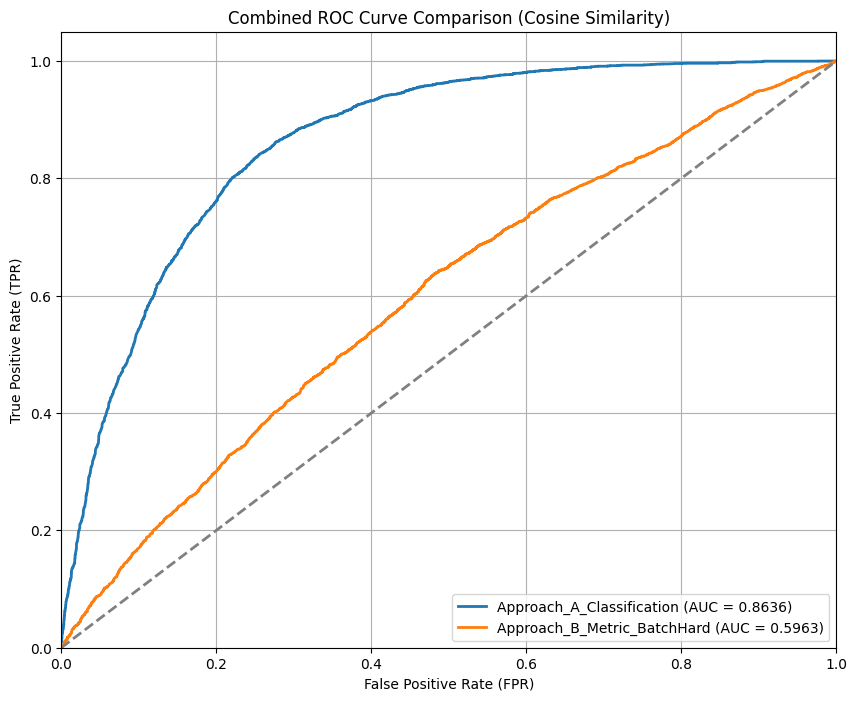

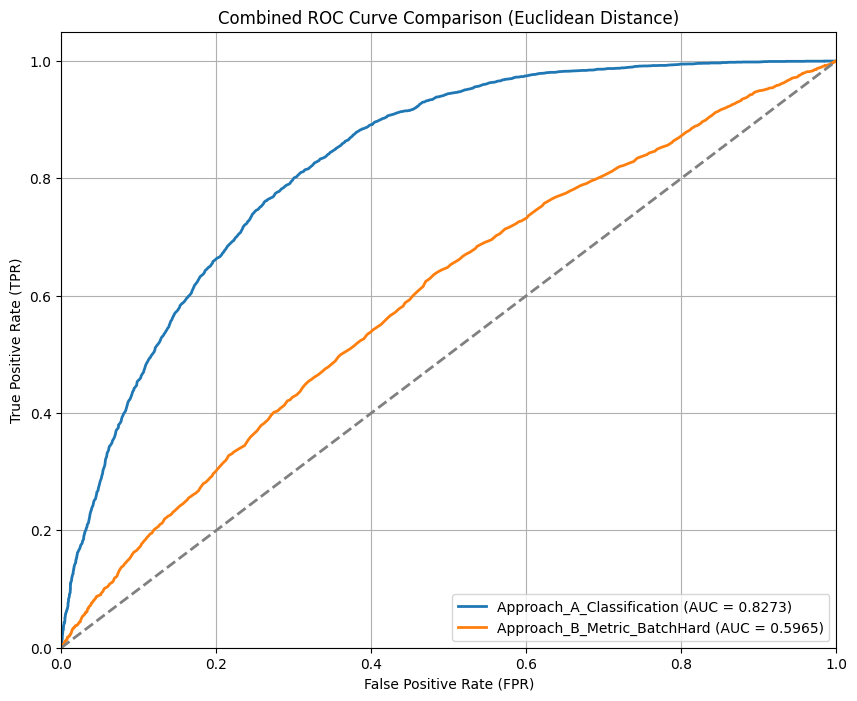

In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from tqdm import tqdm # Provides a progress bar for loops
import os
import gc # Garbage collector, to clear memory

# --- Configuration ---
# Dictionary mapping our model names to their saved file paths
MODELS_TO_EVALUATE = {
    "Approach_A_Classification": "face_embedding_model.keras",
    "Approach_B_Metric_BatchHard": "face_metric_embedder_batch_hard.keras",
}

# --- Constants ---
# As specified in the dataset documentation
PAIRS_FILE_PATH = "/kaggle/input/project-dataset/11-785-fall-20-homework-2-part-2-2/verification_pairs_val.txt"
DATA_ROOT = "/kaggle/input/project-dataset/11-785-fall-20-homework-2-part-2-2/"

# --- Model-Specific Preprocessing Info ---
# Each model was trained with different image sizes and preprocessing
MODEL_CONFIG = {
    "Approach_A_Classification": {
        "img_size": 260,
        "preprocess_func": tf.keras.applications.efficientnet.preprocess_input
    },
    "Approach_B_Metric_BatchHard": {
        "img_size": 384,
        "preprocess_func": tf.keras.applications.efficientnet.preprocess_input
    }
}

# --- Helper Functions ---

def preprocess_image(image_path, data_root, img_size, preprocess_func):
    """
    Loads and preprocesses a single image for the embedding model.
    Handles different path structures.
    """
    try:
        # Construct the full path
        full_path = os.path.join(data_root, image_path)
        if not os.path.exists(full_path):
             # Fallback path if the image is in the 'classification_data' subfolder
             full_path = os.path.join(data_root, "classification_data", image_path)
             if not os.path.exists(full_path):
                print(f"Warning: Could not find image at {os.path.join(data_root, image_path)} or {full_path}")
                return None
        
        img = tf.io.read_file(full_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [img_size, img_size])
        
        if preprocess_func:
            img = preprocess_func(img)
            
        img = tf.expand_dims(img, axis=0) # Add batch dimension
        return img
        
    except Exception as e:
        print(f"Warning: Could not load image {image_path} (from {full_path}). Error: {e}")
        return None

def get_embedding(processed_img, model):
    """Gets the embedding vector from a preprocessed image."""
    if processed_img is None:
        return None
    embedding = model.predict(processed_img, verbose=0)
    return embedding[0]

def cosine_similarity(emb1, emb2):
    """Calculates cosine similarity between two embedding vectors."""
    emb1_norm = emb1 / (np.linalg.norm(emb1) + 1e-6)
    emb2_norm = emb2 / (np.linalg.norm(emb2) + 1e-6)
    return np.dot(emb1_norm, emb2_norm)

def euclidean_distance(emb1, emb2):
    """Calculates Euclidean distance between two embedding vectors."""
    return np.linalg.norm(emb1 - emb2)

# --- Main Evaluation Pipeline ---

def main():
    """
    Main evaluation pipeline to compare both models.
    """
    print(f"Loading verification pairs from {PAIRS_FILE_PATH}...")
    try:
        pairs_df = pd.read_csv(
            PAIRS_FILE_PATH,
            sep=' ',
            header=None,
            names=['img1_path', 'img2_path', 'label']
        )
    except Exception as e:
        print(f"Error loading pairs file: {e}")
        return

    evaluation_results = {} # To store AUC and ROC data for plotting
    
    # --- 1. Loop Through Each Model ---
    for model_name, model_path in MODELS_TO_EVALUATE.items():
        
        print("\n" + "="*70)
        print(f"Evaluating Model: {model_name} ({model_path})")
        print("="*70)

        if not os.path.exists(model_path):
            print(f"Warning: Model file not found at {model_path}. Skipping.")
            continue
            
        if model_name not in MODEL_CONFIG:
            print(f"Warning: Model config not found for {model_name}. Skipping.")
            continue
            
        # Get the specific config (image size, preprocess func) for this model
        config = MODEL_CONFIG[model_name]
        img_size = config['img_size']
        preprocess_func = config['preprocess_func']
        print(f"Using IMG_SIZE={img_size} and preprocessing: {preprocess_func.__name__}")

        # Load the model
        try:
            def l2_normalize(x):
                """Helper function for loading the custom Lambda layer."""
                return tf.math.l2_normalize(x)
        
            custom_objects = {'l2_normalize': l2_normalize}
        
            model = tf.keras.models.load_model(
                model_path, 
                custom_objects=custom_objects # Pass the custom object
            )
            print("Model loaded successfully with custom_objects.")
        except Exception as e:
            print(f"Error loading model: {e}. Skipping.")
            continue
        
        print("Generating unique embeddings (caching)...")
        # Get all unique image paths to avoid processing the same image multiple times
        unique_images = pd.concat([pairs_df['img1_path'], pairs_df['img2_path']]).unique()
        embeddings_cache = {} # Cache embeddings to speed up pair comparison
        
        for img_path in tqdm(unique_images, desc=f"Embedding {model_name}"):
            processed_img = preprocess_image(img_path, DATA_ROOT, img_size, preprocess_func)
            if processed_img is not None:
                embeddings_cache[img_path] = get_embedding(processed_img, model)

        y_true = [] # Ground truth labels (0 or 1)
        y_scores_cosine = [] # Similarity scores (for AUC)
        y_scores_euclidean = [] # Distance scores (for AUC)
        
        print(f"Calculating similarity for {len(pairs_df)} pairs...")
        for _, row in tqdm(pairs_df.iterrows(), total=len(pairs_df), desc=f"Scoring {model_name}"):
            emb1 = embeddings_cache.get(row['img1_path'])
            emb2 = embeddings_cache.get(row['img2_path'])

            # Skip if either embedding failed to generate
            if emb1 is None or emb2 is None:
                continue 

            # Calculate both metrics as required
            cos_sim = cosine_similarity(emb1, emb2)
            euc_dist = euclidean_distance(emb1, emb2)
            
            y_true.append(row['label'])
            y_scores_cosine.append(cos_sim)
            # For Euclidean, lower distance = more similar.
            # We negate it so that higher score = more similar, just like cosine.
            y_scores_euclidean.append(-euc_dist) 

        if not y_true:
            print("Error: No pairs were successfully processed for this model.")
            continue

        # Calculate AUC for both metrics
        auc_cosine = roc_auc_score(y_true, y_scores_cosine)
        auc_euclidean = roc_auc_score(y_true, y_scores_euclidean)
        
        # Calculate ROC Curve data for Cosine
        fpr_cosine, tpr_cosine, _ = roc_curve(y_true, y_scores_cosine)
        
        # --- Calculate ROC Curve data for Euclidean ---
        fpr_euclidean, tpr_euclidean, _ = roc_curve(y_true, y_scores_euclidean)
        
        # Store results for the final plot and table
        evaluation_results[model_name] = {
            "auc_cosine": auc_cosine,
            "auc_euclidean": auc_euclidean,
            "fpr_cosine": fpr_cosine,
            "tpr_cosine": tpr_cosine,
            "fpr_euclidean": fpr_euclidean, # Store Euclidean curve data
            "tpr_euclidean": tpr_euclidean  # Store Euclidean curve data
        }

        print(f"\nResults for {model_name}:")
        print(f"  Cosine Similarity AUC:    {auc_cosine:.4f}")
        print(f"  Euclidean Distance AUC: {auc_euclidean:.4f}")
        
        # Clean up memory before loading the next model
        del model
        gc.collect()
        tf.keras.backend.clear_session()

    # --- 2. Print Final Comparison Table ---
    print("\n" + "="*70)
    print("          Final Model Comparison Report")
    print("="*70)
    print(f"{'Model Name':<30} | {'Cosine AUC':<15} | {'Euclidean AUC':<15}")
    print("-"*70)
    
    for model_name, data in evaluation_results.items():
        print(f"{model_name:<30} | {data['auc_cosine']:<15.4f} | {data['auc_euclidean']:<15.4f}")
    print("="*70)

    # --- 3. Plot Combined ROC Curve (Cosine Similarity) ---
    plt.figure(figsize=(10, 8))
    
    for model_name, data in evaluation_results.items():
        plt.plot(
            data['fpr_cosine'], 
            data['tpr_cosine'], 
            lw=2, 
            label=f"{model_name} (AUC = {data['auc_cosine']:.4f})"
        )
    
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--') # Random guess line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Combined ROC Curve Comparison (Cosine Similarity)')
    plt.legend(loc="lower right")
    plt.grid(True)
    
    roc_plot_path = "roc_curve_comparison.png"
    plt.savefig(roc_plot_path)
    print(f"\nCombined ROC curve plot (Cosine) saved to {roc_plot_path}")

    # --- 4. Plot Combined ROC Curve (Euclidean Distance) ---
    plt.figure(figsize=(10, 8))
    
    for model_name, data in evaluation_results.items():
        plt.plot(
            data['fpr_euclidean'], 
            data['tpr_euclidean'], 
            lw=2, 
            label=f"{model_name} (AUC = {data['auc_euclidean']:.4f})"
        )
    
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--') # Random guess line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Combined ROC Curve Comparison (Euclidean Distance)')
    plt.legend(loc="lower right")
    plt.grid(True)
    
    roc_plot_path_euc = "roc_curve_comparison_euclidean.png"
    plt.savefig(roc_plot_path_euc)
    print(f"Combined ROC curve plot (Euclidean) saved to {roc_plot_path_euc}")
    
if __name__ == "__main__":
    main()